Détermine les 4 couleurs prédominantes sur l'image.  

Novi%20Pazar%20-%20noc.jpg [[ 38.59382015  38.57097866  47.11155225]
 [100.74038836  80.45720223  79.37154176]
 [194.67137491 145.1379414  117.57250188]
 [ 43.78481987  61.88701751  83.72511296]]


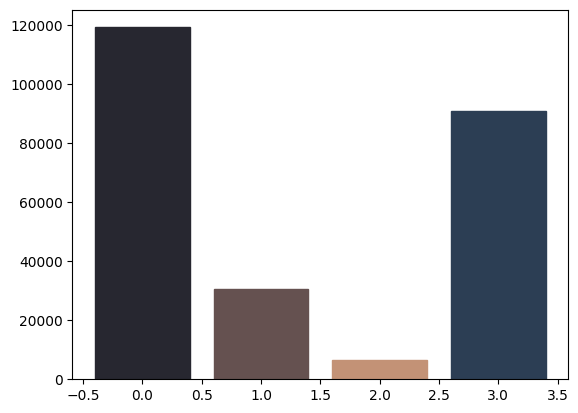

In [21]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
import os

 
# Parcourir les fichiers dans le répertoire d'images
for filename in os.listdir("images"):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Ouvrir l'image pour récupérer ses métadonnées
        with Image.open(os.path.join("images", filename)) as imgfile:
            numarray = numpy.array(imgfile.getdata(), numpy.uint8)
            clusters = KMeans(n_clusters=4, n_init=2)
            clusters.fit(numarray)
            npbins = numpy.arange(0, 5)
            histogram = numpy.histogram(clusters.labels_, bins=npbins)
            labels = numpy.unique(clusters.labels_)
            barlist = plot.bar(labels, histogram[0])
            for i in range(4):
                barlist[i].set_color(
                    "#%02x%02x%02x"
                    % (
                        math.ceil(clusters.cluster_centers_[i][0]),
                        math.ceil(clusters.cluster_centers_[i][1]),
                        math.ceil(clusters.cluster_centers_[i][2]),
                    )
                )
            print(filename, clusters.cluster_centers_)
            plot.show()
            break 

In [6]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
from sklearn.cluster import KMeans
import os

 
def getDominatedColors(imgfile):
    # Parcourir les fichiers dans le répertoire d'images
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = KMeans(n_clusters=4, n_init=2)
    clusters.fit(numarray)
    return clusters.cluster_centers_
    # npbins = numpy.arange(0, 5)
    # histogram = numpy.histogram(clusters.labels_, bins=npbins)
    # labels = numpy.unique(clusters.labels_)
    # barlist = plot.bar(labels, histogram[0])
    # for i in range(4):
    #     barlist[i].set_color(
    #         "#%02x%02x%02x"
    #         % (
    #             math.ceil(clusters.cluster_centers_[i][0]),
    #             math.ceil(clusters.cluster_centers_[i][1]),
    #             math.ceil(clusters.cluster_centers_[i][2]),
    #         )
    #     )
    # print(filename, clusters.cluster_centers_)
    # plot.show()
    # break 

Charge sur CPU :

In [7]:
import os
from PIL import Image
from multiprocessing import Pool


def process_image(filename):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        with Image.open(os.path.join("images", filename)) as imgfile:
            return (filename, getDominatedColors(imgfile))


# Définir le nombre de processus à utiliser (ici 16)
num_processes = 16

# Créer une pool de processus
pool = Pool(processes=num_processes)

# Lister les fichiers d'images
filenames = [f for f in os.listdir("images") if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

# Lancer le traitement en parallèle pour chaque fichier
results = pool.map(process_image, filenames)

# Afficher les résultats
for filename, colors in results:
    print(filename, colors)


15-Nouakchott-eH-R0058185.jpg [[ 99.44570282  77.66529286  85.20276714]
 [ 43.12964144  28.21589381  32.15207723]
 [185.84842702 165.31795046 171.75235649]
 [150.57847512 122.93484524 124.16806533]]
19-03-03-Maribor-RalfR-DJI%200444.jpg [[ 42.76892084  54.07304629  45.37385059]
 [133.04059644  98.23706978  67.74643712]
 [ 35.22925288 113.08665889 153.50216103]
 [169.60242169 169.94659453 169.99834846]]
Addis%20abeba%20meskele%20square.jpg [[134.7505977  116.80942715  86.02120369]
 [207.03191431 200.87918352 171.00993932]
 [ 56.66247546  59.00933149  48.57980096]
 [104.45274238 164.94540355 205.95157278]]
08%20b%20piazza%20cavour%20pan%20301.jpg [[ 57.03836776  41.75472215  35.89360394]
 [192.27593809 166.73020031 143.37288581]
 [ 72.92535889 102.77611206 188.63546828]
 [122.95094202  88.53062017  71.92548076]]
20200809%20Taipei%2C%20Taiwan%20Skyline.jpg [[229.3161107  238.09176136 235.81355183]
 [ 38.36095453  62.53180372  48.83197488]
 [105.06649837 128.57607186 126.45720379]
 [160.64

(non fonctionnel) Sur gpu

In [5]:
from typing import Tuple
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import os
from multiprocessing import Pool
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self, n_clusters: int = 4):
        self.n_clusters = n_clusters
        self.clusters = None

    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, imgfile: Image):
        numarray = np.array(imgfile.getdata(), np.uint8)
        self.clusters = KMeans(n_clusters=self.n_clusters, n_init=2)
        self.clusters.fit(numarray)
        
    def predict(self, imgfile: Image) -> np.ndarray:
        if not self.clusters:
            raise ValueError('Model not trained')
        numarray = np.array(imgfile.getdata(), np.uint8)
        return self.clusters.predict(numarray)
    
    def get_dominated_colors(self, imgfile: Image) -> np.ndarray:
        if not self.clusters:
            self.fit(imgfile)
        return self.clusters.cluster_centers_




# Vérifier la disponibilité de CUDA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Charger le modèle sur le GPU
model = MyModel().to(device)

def process_image(filename):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        with Image.open(os.path.join("images", filename)) as imgfile:
            # Charger l'image sur le GPU
            img = torch.from_numpy(np.array(imgfile)).to(device)
            # Faire passer l'image dans le modèle
            result = model(img)
            return (filename, result)


# Définir le nombre de processus à utiliser (ici 3)
num_processes = 3

# Créer une pool de processus
pool = Pool(processes=num_processes)

# Lister les fichiers d'images
filenames = [f for f in os.listdir("images") if f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.png')]

# Lancer le traitement en parallèle pour chaque fichier
results = pool.map(process_image, filenames)

# Afficher les résultats
for filename, result in results:
    print(filename, result)


RuntimeError: Input type (unsigned char) and bias type (float) should be the same